In [1]:
# https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b
# https://www.kaggle.com/code/prashant111/complete-guide-on-time-series-analysis-in-python

In [2]:
import pandas as pd
import numpy as np
import json
from math import ceil
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

In [3]:
from scipy.stats import zscore
import pingouin as pq
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.holtwinters import Holt
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from stargazer.stargazer import Stargazer, LineLocation, Label
from scipy.stats import pearsonr, boxcox

In [4]:
import warnings
from statsmodels.tools.sm_exceptions import InterpolationWarning
warnings.simplefilter('ignore', InterpolationWarning)

In [5]:
from statsmodels.tools.sm_exceptions import  ValueWarning 
warnings.simplefilter('ignore', ValueWarning)
# https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.html

## Utils

In [6]:
def cos2ang(cosine_similarity):
    
    angular = np.arccos(cosine_similarity) / np.pi # Noble et al
    # angular = (1 / cosine_similarity(v1, v2)) / np.pi # https://www.itl.nist.gov/div898/software/dataplot/refman2/auxillar/cosdist.htm

    return 1 - angular

In [7]:
# cos2ang(0)

In [8]:
def get_time_mapper(file_path):
    with open(Path(file_path)) as f:
        mapper = json.loads(f.read())
        mapper = {int(k): v for k,v in mapper.items()}
        return mapper

In [9]:
M_mapper = get_time_mapper("../utils/M_mapper.json")
Q_mapper = get_time_mapper("../utils/Q_mapper.json")

In [10]:
# Q_mapper

In [11]:
# M_mapper

In [12]:
# {v: k for k, v in M_mapper.items()}["2018/January"]

In [13]:
# {v: k for k, v in Q_mapper.items()}["2012/Q1"]

In [14]:
def select(df, term, community, meas, fill = None, minT = None, maxT = None):
    data = df[(df["DWE"]==term)&(df["Community"]==community)][[meas, "T"]]
    if fill != None:
        data[meas] = data[meas].fillna(fill)
    if minT != None:
        data = data[data["T"] >= minT]
    if maxT != None:
        data = data[data["T"] <= maxT]

    return data

In [15]:
def adjusted(data, i_var, f_var, name, fill=None, first_fill=None): # adjust i_var (e.g. intensity) relative f_var (e.g. frequencey)
    """ 
    Adjusted Intensity (AI) = residuals of regression i_var ~ f_var, e.g. the intensity not explained by frequency.
    Should be done for term, community pairs (not data overall).
    """
    # data = data.copy()
    block = [] # communities
    for community in pd.unique(data["Community"]):
        # d_block = [] # DWEs ...
        for term in pd.unique(data["DWE"]):
            df = data[(data["DWE"]==term) & (data["Community"]==community)].copy()
            # df = df[[i_var, f_var]].dropna()
            df = df[[i_var, f_var]].copy()

            # return df
            if df.shape[0] < 3: 
                print(term, community, df.shape, list(df.index))
                continue            
            # df = df.sample(frac=1) # avoid auto-regression

            if fill != None:
                if fill == "interpolate":
                    df[i_var] = df[i_var].interpolate()                
                elif fill == "spline":
                    df[i_var] = df[i_var].interpolate(option="spline")                
                elif fill == "min":
                    minimum = df[i_var].min()
                    df[i_var] = df[i_var].fillna(minimum)                
                elif fill == "mean":
                    mean = df[i_var].mean()
                    df[i_var] = df[i_var].fillna(mean)
                elif fill == "previous":
                    if pd.isna(df.iloc[0][i_var]):
                        if first_fill == "min":
                            first_fill = df[i_var].min()
                        if first_fill == "mean":
                            first_fill = df[i_var].mean()                        
                        if first_fill == "next":
                            first_fill = [v for v in df[i_var] if not pd.isna(v)][0]                            
                        df.at[0, i_var] = first_fill # df.iloc[0][i_var] = first_fill
                    df[i_var] = df[i_var].ffill()
                else:
                    df[i_var] = df[i_var].fillna(fill) 
            else:
                df = df.dropna()

            model = smf.ols(formula=f"{i_var} ~ {f_var}", data=df, missing='drop').fit()
            # print(term, community, model.resid)
            # adj = pd.Series(model.resid, index=df.index, dtype = np.float64, name=name) # dtype=None
            adj = model.resid.rename(name)
            block.append(adj)
    adj_col = pd.concat(block, axis=0)

    return adj_col

In [16]:
def q2d(string, time_type):
    if time_type == "quarterly":
        y, q = tuple(string.split("/Q"))
        q = int(q) * 3
        d = calendar.monthrange(int(y), q)[1]
        return np.datetime64(f"{y}-{q:02d}-{d:02d}") # Obs! represent quarter as last day of last month
    else: # i.e. "monthly"
        y, m = tuple(string.split("/"))
        m = {m: i for i, m in enumerate(calendar.month_name)}[m] 
        # ['', 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
        d = calendar.monthrange(int(y), m)[1]
        return np.datetime64(f"{y}-{m:02d}-{d:02d}") # Obs! represent month as last day of last month        

In [17]:
# calendar.monthrange(2010, 1)[1]

In [18]:
def add_date(df, mapper, set_as_index=True, time_type="quarterly"):
    df = df.copy()
    df["date"] = [q2d(mapper[int(idx.split("-")[0])], time_type) for idx in df.index]
    if set_as_index:
        # df.set_index("date", inplace=True)
        df.index = pd.DatetimeIndex(df["date"], freq="infer")
    return df

In [19]:
# add_date(glob_fb, Q_mapper).index

### Elections

In [20]:
election_years = [2002, 2006, 2010, 2014, 2018, 2022]

In [21]:
election_days = [
    (2002, 9, 15),
    (2006, 9, 17),
    (2010, 9, 19),
    (2014, 9, 14),
    (2018, 9, 9),
    (2022, 9, 11)
]

## Data

In [22]:
# PATH = "long_data"
PATH = "long_data_no_min"                       # <-- Paper
# FILE = Path(f"{PATH}/long_spec_q_rn.csv")
# FILE = Path(f"{PATH}/long_all_q_rn.csv")
# FILE = Path(f"{PATH}/long_spec_m_rn.csv")
# FILE = Path(f"{PATH}/long_all_m_rn.csv")
FILE = Path(f"{PATH}/sbert_long_spec_q_rn.csv") # <-- Paper
# FILE = Path(f"{PATH}/sbert_mixed_long_all_q_rn.csv")

In [23]:
sqdf = pd.read_csv(FILE, sep="\t", index_col=0)

In [24]:
# sqdf 

#### Add date

In [25]:
sqdf = add_date(sqdf, Q_mapper, set_as_index=False)
# sqdf = add_date(sqdf, M_mapper, set_as_index=False, time_type="monthly")

In [26]:
# sqdf["date"]

*Select time before detrending* 

In [ ]:
YEAR = 2010
MONTH = 1
DAY = 1
sqdf = sqdf[sqdf["date"] > pd.Timestamp(year=YEAR, month=MONTH, day=DAY)].copy()

## Adjusting & detrending

### Add adjusted terms

#### Intensity

In [ ]:
adj_int = adjusted(data=sqdf, i_var="I_ang", f_var="fpm_lg", name="I_ang_adj")
sqdf = pd.concat([sqdf, adj_int], axis=1)

#### Normalized intensity

In [ ]:
adj_ssc = adjusted(data=sqdf, i_var="cnt_ssc", f_var="fpm_lg", name="ssc_adj")
sqdf = pd.concat([sqdf, adj_ssc], axis=1)

In [ ]:
# sqdf

In [ ]:
# d = {type(x): x for x in sqdf["I_ang_adj"]}
# d

### Detrending

In [ ]:
# detrend_int = adjusted(data=sqdf, i_var="I_ang", f_var="T", name="I_ang_dtr")
# sqdf = pd.concat([sqdf, detrend_int], axis=1)

In [ ]:
# sqdf["Community"].unique()

In [ ]:
# sqdf[pd.isna(sqdf["Community"])]

In [ ]:
# ### WITH FILL ###
FILL = [
    # None,
    # 0.5,
    # "min",
    "mean",
    # "previous"
][0]
FIRST_FILL = "next"
detrend_int = adjusted(data=sqdf, i_var="I_ang", f_var="T", name="I_ang_dtr", fill=FILL, first_fill=FIRST_FILL)
sqdf = pd.concat([sqdf, detrend_int], axis=1)
# sqdf["I_ang_dtr"].interpolate(inplace=True)

In [ ]:
# detrend_ssc = adjusted(data=sqdf, i_var="cnt_ssc", f_var="T", name="ssc_dtr")
detrend_ssc = adjusted(data=sqdf, i_var="cnt_ssc", f_var="T", name="ssc_dtr", fill=FILL, first_fill=FIRST_FILL)
# detrend_ssc
sqdf = pd.concat([sqdf, detrend_ssc], axis=1)
# sqdf["ssc_dtr"].interpolate(inplace=True)

In [ ]:
detrend_fpm = adjusted(data=sqdf, i_var="fpm_0", f_var="T", name="fpm_dtr")
sqdf = pd.concat([sqdf, detrend_fpm], axis=1)
sqdf["fpm_dtr"].interpolate(inplace=True)

#### Detrending adjusted

In [ ]:
detrend_int_adj = adjusted(data=sqdf, i_var="I_ang_adj", f_var="T", name="I_ang_adj_dtr")
sqdf = pd.concat([sqdf, detrend_int_adj], axis=1)

In [ ]:
detrend_ssc_adj = adjusted(data=sqdf, i_var="ssc_adj", f_var="T", name="ssc_adj_dtr")
sqdf = pd.concat([sqdf, detrend_ssc_adj], axis=1)

### `I_ang_0`

In [ ]:
sqdf["I_ang_0"] = sqdf["I_ang"].fillna(0.5)

In [ ]:
def filler(data, variable, fill, first_fill=None):
    block = [] # communities
    for community in pd.unique(data["Community"]):
        # d_block = [] # DWEs ...
        for term in pd.unique(data["DWE"]):
            df = data[(data["DWE"]==term) & (data["Community"]==community)].copy()
            # df = df[[i_var, f_var]].dropna()
            s = df[variable].copy()

            # return df
            # if df.shape[0] < 3: 
            #     print(term, community, df.shape, list(df.index))
            #     continue            
            # df = df.sample(frac=1) # avoid auto-regression

            if fill != None:
                if fill == "mean":
                    mean = df[i_var].mean()
                    s = s.fillna(mean)
                elif fill == "previous":
                    if pd.isna(s.iloc[0]):
                        if first_fill == "min":
                            first_fill = s.min()
                        if first_fill == "mean":
                            first_fill = s.mean()                        
                        if first_fill == "next":
                            first_fill = [v for v in s if not pd.isna(v)][0]                            
                        s.iloc[0] = first_fill # df.iloc[0][i_var] = first_fill
                    s = s.ffill()
                else:
                    s = s.fillna(fill) 

            block.append(s)
    adj_col = pd.concat(block, axis=0)
    return adj_col

In [ ]:
sqdf["I_ang_XXX"] = filler(data=sqdf, variable="I_ang", fill=0.5)#, first_fill="next")

In [ ]:
# sqdf

In [ ]:
# r_expr = f'I_ang ~ fpm_0'
# results = smf.ols(formula=r_expr, data=sqdf, missing='drop').fit() 
# print(results.summary())

## Visual

In [ ]:
def krename(string):
    new = string.replace("kultur", "") + "_kultur" if string.startswith("kultur") else string
    return new

In [ ]:
def visual(
    dataframe, 
    terms, 
    community, 
    meas, 
    step, 
    vline, 
    start = None,
    norm = False
):
    # fig = plt.figure(figsize=(12, 3))
    fig, axs = plt.subplots(len(terms), 1, figsize=(8,len(terms)*1.7))#, sharey=True, sharex=False)

    DATA = dataframe[(dataframe["DWE"].isin(terms)) & (dataframe["Community_name"]==community)]

    if start != None:
        YEAR, MONTH, DAY = start
        DATA = DATA[DATA["date"] >= pd.Timestamp(year=YEAR, month=MONTH, day=DAY)]

    series = [DATA[DATA["DWE"]==dwe].set_index("date")[meas] for dwe in terms]

    # return series

    series, terms = zip(*sorted([(ts, krename(term[3:])) for ts, term in zip(series, terms)], key= lambda x: x[-1]))
    
    for ts, term, ax in zip(series, terms, axs.flatten()):
        Y = ts
        X = ts.index
        if norm:
            Y = zscore(Y, nan_policy="omit")
        
        ax.plot(X, Y)

        title = f"{term}, {meas}"
        
        ax.set_title(title, size=11)

        for YEAR, MONTH, DAY in election_days:
            if start != None:
                if YEAR < start[0]:
                    continue
            ax.axvline(pd.Timestamp(year=YEAR, month=MONTH, day=DAY), linewidth=3, color="red")
        
        # for ey in election_years:
        #     ax.axvline(pd.Timestamp(year=ey, month=9, day=1), linewidth=3, color="red")
    fig.tight_layout()
    plt.show()

In [ ]:
visual(
    dataframe = sqdf, 
    terms     = pd.unique(sqdf["DWE"]), 
    community = "Flashback", 
    meas      = "I_ang_dtr", 
    step      = 1, 
    vline     = election_years, 
    start     = (2010, 1, 1),
    norm      = False,
)

In [ ]:
visual(
    dataframe = sqdf, 
    terms     = pd.unique(sqdf["DWE"]), 
    community = "Familjeliv", 
    meas      = "I_ang_dtr", 
    step      = 1, 
    vline     = election_years, 
    start     = (2008, 1, 1),
    norm      = False,
)

In [ ]:
def vis_trend(
    dataframe, 
    terms, 
    community, 
    meas, 
    step, 
    # vline, 
    ncols = 2,
    start = None,
    norm = False
):
    
    DATA = dataframe[(dataframe["DWE"].isin(terms)) & (dataframe["Community_name"]==community)]
    if start != None:
        YEAR, MONTH, DAY = start
        DATA = DATA[DATA["date"] >= pd.Timestamp(year=YEAR, month=MONTH, day=DAY)]
    series = [DATA[DATA["DWE"]==dwe].set_index("date")[meas] for dwe in terms]
    series, terms = zip(*sorted([(ts, krename(term[3:])) for ts, term in zip(series, terms)], key= lambda x: x[-1]))

    fig, axs = plt.subplots(ceil(len(terms)/ncols), ncols, figsize=(len(terms), len(terms)))#, sharey=True, sharex=False)
    for ts, term, ax in zip(series, terms, axs.flatten()):
        Y = ts
        X = np.arange(len(Y))
        if len(Y.dropna()) < 5:
            continue
        if norm:
            Y = zscore(Y, nan_policy="omit")

        sns.regplot(x=X, y=Y, ax=ax)
        payload = pd.DataFrame(zip(X,Y), columns=["X", "Y"]).dropna()
        r, p = pearsonr(payload["X"],payload["Y"])
        title = f"{term}, {meas} \n(r={r:.2f}, p={p:.2f}, N={payload.shape[0]})"
        ax.set_title(title, size=9)
    fig.tight_layout()
    plt.show()

In [ ]:
vis_trend(
    dataframe = sqdf, 
    terms     = pd.unique(sqdf["DWE"]), 
    community = "Flashback", 
    meas      = "I_ang", 
    step      = 1, 
    vline     = election_years, 
    start     = (2010, 1, 1),
    norm      = False,
    ncols     = 3
)

In [ ]:
vis_trend(
    dataframe = sqdf, 
    terms     = pd.unique(sqdf["DWE"]), 
    community = "Familjeliv", 
    meas      = "I_ang", 
    step      = 1, 
    # vline     = election_years, 
    start     = (2010, 1, 1),
    norm      = False,
    ncols     = 3
)

In [ ]:
vis_trend(
    dataframe = sqdf, 
    terms     = pd.unique(sqdf["DWE"]), 
    community = "Flashback", 
    meas      = "I_ang_XXX", 
    step      = 1, 
    # vline     = election_years, 
    start     = (2010, 1, 1),
    norm      = False,
    ncols     = 3
)

In [ ]:
vis_trend(
    dataframe = sqdf, 
    terms     = pd.unique(sqdf["DWE"]), 
    community = "Familjeliv", 
    meas      = "I_ang_0", 
    step      = 1, 
    vline     = election_years, 
    start     = (2010, 1, 1),
    norm      = False,
    ncols     = 3
)

## Naive lagged correlations

In [ ]:
def corr4u(df):
    df = df.dropna()
    if len(df) < 2:
        return None
    x, y = tuple(df.columns)
    x, y = df[x], df[y]
    return pearsonr(x,y).correlation

In [ ]:
def m_corr(df, meas, trg="Familjeliv", nlags=4):
    results = []
    for dwe in pd.unique(sqdf["DWE"]):
        # print(dwe)
        ref = [c for c in pd.unique(df["Community_name"]) if c != trg][0]
        A = df[(df["DWE"]==dwe) & (df["Community_name"]==trg)][meas].values
        B = df[(df["DWE"]==dwe) & (df["Community_name"]==ref)][meas].values
        this = pd.DataFrame(zip(A, B), columns=["Trg", "Ref-0"])
        for i in range(1, nlags+1):
            this[f"Ref-{i}"] = this["Ref-0"].shift(i)
        # return this
        d = {"Term": dwe}
        for lag in [c for c in sorted(this.columns) if c != "Trg"]:
            r = corr4u(this[["Trg", lag]])
            d[lag] = r
        results.append(d)
    results = pd.DataFrame(results) 
    results.set_index("Term", inplace=True)
    return results

In [ ]:
TRG = "Familjeliv"
MEAS = "I_ang_adj_dtr"
# TRG = "Flashback"
payload = m_corr(sqdf, meas=MEAS, trg=TRG, nlags=8)
# payload
sns.heatmap(payload, annot=True)
plt.title(f'Lagged Correlations (ref={TRG})')

## TS: Utils

In [27]:
def find_lag(payload):
    model = VAR(payload.dropna())
    # Determining the optimal lag order
    lag_order_results = model.select_order(maxlags=4)
    tab = pd.DataFrame(lag_order_results.ics).drop(0)
    for c in tab.columns:
        tab[f"{c}_bool"] = tab[c].apply(lambda x: True if x == tab[c].min() else False)
    tab["pool"] = tab[[c for c in tab.columns if c.endswith("_bool")]].sum(axis=1)
    pool_max    = tab.pool.max()
    tab         = tab[tab.pool == pool_max]

    if tab.index.shape[0] > 1:
        for ics in ["aic_bool", "fpe_bool", "bic_bool", "hqic_bool"]: # preferred measure order
            for i in tab.index:
                if tab.at[i, ics]:
                    return i
    else:
        return tab.index[0]


In [28]:
def differencing(data, variable):
    # data = data.copy()
    diff = data[variable] - data[variable].shift(1)
    return diff   

In [29]:
def df_for_var(df, term, variable, fillNAN=None, first_fill=None):
    df = df.copy()
    df.index = pd.DatetimeIndex(df["date"], freq="infer")
    
    fb = df[(df["Community_name"] == "Flashback")  & (df["DWE"] == term)][variable].rename("fb")
    fl = df[(df["Community_name"] == "Familjeliv") & (df["DWE"] == term)][variable].rename("fl")
    
    if fillNAN != None:
        if fillNAN == "interpolate":
            fb.interpolate(inplace=True)
            fl.interpolate(inplace=True)
        elif fillNAN == "spline":
            fb.interpolate(option="spline", inplace=True)
            fl.interpolate(option="spline", inplace=True)            
        elif fillNAN == "min":
            min_fb = fb.min()
            min_fl = fl.min()
            fb.fillna(min_fb, inplace=True)
            fl.fillna(min_fl, inplace=True)            
        elif fillNAN == "mean":
            M_fb = fb.mean()
            M_fl = fl.mean()
            fb.fillna(M_fb, inplace=True)
            fl.fillna(M_fl, inplace=True)
        elif fillNAN == "previous":
            for s in [fb, fl]:
                if pd.isna(s.iloc[0]):
                    if first_fill == "min":
                        first_fill = s.min()
                    if first_fill == "next":
                        first_fill = [v for v in s if not pd.isna(v)][0]
                    s.iloc[0] = first_fill # df.iloc[0][cmt] = first_fill
                s.ffill(inplace=True) 
        else:
            fb.fillna(fillNAN, inplace=True)
            fl.fillna(fillNAN, inplace=True)
    return pd.concat([fb,fl], axis=1)

In [30]:
# cmt = "fb"
# term = "N1_återvandring"
# orig = df_for_var(sqdf[sqdf["date"] > pd.Timestamp(year=YEAR, month=MONTH, day=MONTH)], term, "I_ang", "previous", "next")
# # orig = df_for_var(sqdf[sqdf["date"] > pd.Timestamp(year=YEAR, month=MONTH, day=MONTH)], TERM, "cnt_ssc", 0.5)
# plt.plot(zscore(orig[cmt], nan_policy="omit"), label="Orig", linestyle='dashed')
# plt.scatter(x=orig.index, y=zscore(orig[cmt], nan_policy="omit"), s=10)

## TS: Stationarity

### Tests

In [31]:
def adf_test(timeseries, verbose=False, full_output=False):
    dftest = adfuller(timeseries, autolag="AIC")
    if dftest[1] > 0.05:
        if verbose:
            print(f"\tNon-stationary (p={dftest[1]:.3f}) acc. to ADF.")
        return False
    else:
        if verbose:
            print(f"\tStationary (p={dftest[1]:.3f}) acc. to ADF.")
        return True
    if full_output:
        print("Results of Dickey-Fuller Test:")
        dfoutput = pd.Series(
            dftest[0:4],
            index=[
                "Test Statistic",
                "p-value",
                "#Lags Used",
                "Number of Observations Used",
            ],
        )
        for key, value in dftest[4].items():
            dfoutput["Critical Value (%s)" % key] = value
        print(dfoutput)

In [32]:
def kpss_test(timeseries, verbose=False, full_output=False):
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    if kpsstest[1] <= 0.05:
        if verbose:
            print(f"\tNon-stationary (p={kpsstest[1]:.3f}) acc. to KPSS.")
        return False
    else:
        if verbose:
            print(f"\tStationary (p={kpsstest[1]:.3f}) acc. to KPSS.")
        return True
    if full_output:
        print("Results of KPSS Test:")
        kpss_output = pd.Series(
            kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
        )
        for key, value in kpsstest[3].items():
            kpss_output["Critical Value (%s)" % key] = value
        print(kpss_output)

In [33]:
# def variance_ratio(ts, lag = 2):
#     """
#     Returns the variance ratio test result
#     """
#     # make sure we are working with an array, convert if necessary
#     ts = np.asarray(ts)
    
#     # Apply the formula to calculate the test
#     n = len(ts)
#     mu  = sum(ts[1:n]-ts[:n-1])/n;
#     m=(n-lag+1)*(1-lag/n);
#     b=sum(np.square(ts[1:n]-ts[:n-1]-mu))/(n-1)
#     t=sum(np.square(ts[lag:n]-ts[:n-lag]-lag*mu))/m
#     return t/(lag*b)

### Utils

In [ ]:
def add_const(arr):
    k = min(arr)
    k = abs(k)
    k += 0.1
    return k

In [ ]:
def holt(ts, sl=0.1):
    model = Holt(ts).fit(sl)
    trend = model.fittedvalues
    return ts - trend

In [ ]:
def collecter(df, term, community, I_ang_fill = 0.5, I_ang_first_fill = None):

    results = []

    payload = df_for_var(df, term, "I_ang", I_ang_fill, I_ang_first_fill) # <-- Obs!
    results.append(payload[community].rename(f"I_ang"))
    
    # payload = df_for_var(df, term, "I_ang_dtr", None)
    # results.append(payload[community].rename(f"I_ang_dtr"))

    payload = df_for_var(df, term, "cnt_ssc", 0.5) 
    results.append(payload[community].rename(f"cnt_ssc"))  

    # payload = df_for_var(df, term, "ssc_dtr", None) 
    # results.append(payload[community].rename(f"ssc_dtr")) 
    
    # payload = df_for_var(df, term, "I_ang_adj_dtr", 0)
    # results.append(payload[community].rename(f"I_ang_adj_dtr"))

    results = pd.concat(results, axis=1)

    # for col in results.columns:
    #     results[f"{col}_bc"] = boxcox( results[col] + add_const(results[col]) )[0]

        
    # for col in results.columns:
    #     if col.endswith("_dtr"):
    #         continue
    #     else:
    #         results[f"{col}_holt"] = holt(results[col])

    for col in results.columns:
        results[f"{col}_diff"] = results[col] - results[col].shift(1)

    return results

In [ ]:
def stationary_overview(df, year, month, day, terms, I_ang_fill, I_ang_first_fill):

    df = df[df["date"] > pd.Timestamp(year=year, month=month, day=day)].copy()

    results = []

    for term in terms:
        for community in ["fb", "fl"]:
            payload = collecter(df, term, community, I_ang_fill, I_ang_first_fill)
            d = {"Label": f"{term}_{community}"}
            for col in payload.columns:
                for label, test in [("_adf", adf_test), ("_kpss", kpss_test)]:#, ("_vr", variance_ratio)]:
                    d.update({f"{col}{label.upper()}": test(payload[col].dropna())})
            results.append(d)

    print(f"N={payload.shape[0]}")
    return pd.DataFrame(results)
    

### Run

In [ ]:
DWEs = [
    "N1_globalist",
    "N1_återvandring",
    # "V1_återvandra",
    "V1_berika",
    # "N1_kulturberikare"
]

In [ ]:
YEAR = 2010
MONTH = 1
DAY = 1
# FILL = 0.5
# FILL = "previous"
# FILL = "min"
FILL = "mean"
FIRST_FILL = "next"
res = stationary_overview(df=sqdf, year=YEAR, month=MONTH, day=DAY, terms=DWEs, I_ang_fill=FILL, I_ang_first_fill=FIRST_FILL)
res.set_index("Label", inplace=True)
plt.figure(figsize=(12,3))
sns.heatmap(res, annot=True, linewidths=1, linecolor='black', cbar=False)
plt.title('Stationary?')
plt.show()

In [ ]:
MEAS, FILL, FIRST_FILL = "I_ang", "previous", "next"
TERM = "N1_återvandring"
payload = df_for_var(sqdf, TERM, MEAS, FILL, FIRST_FILL) # <-- Obs!
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(payload["fb"].dropna().to_list(), lags=30, ax=axes[0]) 
plot_acf(payload["fl"].dropna().to_list(), lags=30, ax=axes[1])
plt.show()

In [ ]:
MEAS, FILL, FIRST_FILL = "I_ang", "previous", "next"
YEAR = 2010
MONTH = 1
DAY = 1

DIFF   = False
BOXCOX = False
HOLT   = False

for TERM in DWEs:
    print(TERM.upper())
    payload = df_for_var(sqdf[sqdf["date"] > pd.Timestamp(year=YEAR, month=MONTH, day=DAY)], TERM, MEASURE, FILL, FIRST_FILL)

    fb = payload["fb"].dropna()
    fl = payload["fl"].dropna()
    
    if BOXCOX:
        # plt.plot(fb + const(fb), label="fb_"+TERM)
        # plt.plot(fl + const(fl), label="fl_"+TERM)

        fb = boxcox(fb + const(fb) )[0] 
        fl = boxcox(fl + const(fl) )[0]   

    if HOLT:
        fb = holt(fb)
        fl = holt(fl)
    
    if DIFF:
        fb = fb - fb.shift(1)
        fl = fl - fl.shift(1)
    
    print("Flashback")
    kpss_test(fb.dropna(), verbose=True)
    adf_test(fb.dropna(), verbose=True)
    
    print("Familjeliv")
    kpss_test(fl.dropna(), verbose=True)
    adf_test(fl.dropna(), verbose=True)
    print()
# plt.legend()
# plt.show

## TS: VAR

### Utils

In [34]:
def find_order_var(ts_df, rng=10):
    results = []
    rng = np.arange(1, rng)
    for i in rng:
        model = VAR(ts_df.dropna()).fit(i)
        d = {"AIC": model.aic, "BIC": model.bic}
        results.append(d)
    df = pd.DataFrame(results)
    df.index = rng
    df["AIC_pref"] = df["AIC"].apply(lambda x: x == df["AIC"].min())
    df["BIC_pref"] = df["BIC"].apply(lambda x: x == df["BIC"].min())
    return df

In [35]:
def pair_vis(df, ts_a="fb", ts_b="fl", norm=True, verbose_n_lags=None):
    df = df.copy()
    plt.figure(figsize=(12, 6), dpi=80)
    x = df.index
    plt.plot(x, zscore(df[ts_a], nan_policy="omit"), label=ts_a)
    plt.plot(x, zscore(df[ts_b], nan_policy="omit"), label=ts_b)
    if verbose_n_lags != None:   
        for i in range(verbose_n_lags+1):
            df["shift_A"] = df[ts_a].shift(i) # <-- Direction of shift!
            # if i > 0: # CHECK SHIFT!
            #     return df
            this_df = df[["shift_A", ts_b]].dropna()
            A, B = this_df["shift_A"], this_df[ts_b]
            corr, pval = pearsonr(A,B)
            print(f"For lag={i}, r={corr:.2f} (p={pval:.3f})")
    plt.legend()
    plt.show()

In [36]:
def pair_vis_lag(df, lag, ts_a="fb", ts_b="fl", norm=True, lags=None):
    df = df.copy()
    plt.figure(figsize=(12, 6), dpi=80)
    x = df.index
    df[ts_a] = zscore(df[ts_a], nan_policy="omit")
    a = df[ts_a].shift(lag)
    plt.plot(x, a, label=ts_a)

    plt.plot(x, zscore(df[ts_b], nan_policy="omit"), label=ts_b)

    plt.legend()
    plt.show()

In [37]:
def pd2dict(df):
    n_lags = len(set([row.split(".")[0] for row in df.index if row.startswith("L")]))

    d = {IV: {DV: {f"L{i}": None for i in range(1, n_lags+1)} for DV in df.columns} for IV in df.columns}
    for dv in df.columns:
        for iv in df.columns:
            for lag in [f"L{lag}" for lag in range(1, n_lags+1)]:
                value = df.loc[f"{lag}.{iv}"][dv]
                d[dv][iv][lag] = value
    return d    

In [38]:
def star(p):
    if p > 0.05:
        if p <= 0.1:
            return "†"
        else:
            return ""
    else:
        if p > 0.001:
            if p <= 0.01:
                return "**"
            else:
                return "*"
        else:
            return "***"    

In [39]:
def ziggy_column(results, name=None, round=3):

    coefficients = pd2dict(results.params.round(round))
    std_errors   = pd2dict(results.bse.round(round))
    pvalues      = pd2dict(results.pvalues.round(round))

    variables = coefficients.keys()

    nlags = len(set([row.split(".")[0] for row in results.params.index if row.startswith("L")]))

    what     = []
    how_much = []

    for I in variables:
        for counter, J in enumerate(variables):
            for lag in [f"L{i}" for i in range(1, nlags+1)]:
                what.append(f"{I}<--{J}_{lag}")
                asterix = star(pvalues[I][J][lag]) 
                how_much.append(f"{coefficients[I][J][lag]}{asterix}")
                what.append(f"{I}<--{J}_{lag}.sd")#"sd"+I+J+lag)
                how_much.append(f"({std_errors[I][J][lag]})")

    N = results.nobs

    what = pd.Series(what)
    
    how_much = pd.Series(how_much)
    if name != None:
        how_much.rename(name, inplace=True)

    df = pd.concat([what, how_much], axis = 1)

    df.set_index(0, inplace=True)

    return df  

In [40]:
def ziggy(models, names = None, mapper=None):

    # return ziggy_column(models[1])
    if names == None:
        names = [str(i) for i in range(1, len(models)+1)]
        
    df = pd.concat([ziggy_column(model, name=name) for model, name in zip(models, names)], axis = 1)

    df.sort_index(inplace=True)

    df["scratch"] = df.index
    df[["Equation", "Variable"]] = df["scratch"].str.split('<--', expand=True)
    # df[["Variable", "Lag"]] = df["bar"].str.split('_', expand=True)
    
    #df["Equation"] = df["Equation"].apply(lambda x: "" if x.endswith("sd") else x)
    df["Variable"] = df["Variable"].apply(lambda x: "" if x.endswith("sd") else x)

    df["Equation"] = np.where(df["Variable"] == "", "", df["Equation"]) 
    
    df.reset_index(inplace=True)
    df = df[["Equation", "Variable"] + names]
    # df.drop([["scratch", "0"]], axis=1, inplace=True)

    if mapper != None:
        df["Equation"] = df["Equation"].map(mapper)
        df["Variable"] = df["Variable"].map(mapper)

    df.fillna("", inplace=True)
    return df

In [41]:
# ziggy(MODELS, M_NAMES, MAPPER)

In [42]:
def skewie():
    payload = df_for_var(sqdf[sqdf["date"] > pd.Timestamp(year=YEAR, month=MONTH, day=MONTH)], TERM, MEASURE, FILL)
    plt.hist(payload["fb"])
    plt.show()
    plt.hist(payload["fl"])
    plt.show()

In [43]:
def walliz(x):
    z = x / (1-x)
    z = np.log(z)
    return z

## Run VAR models 

### Visualize

In [ ]:
ALPHA = 1.0
MEAS, DTR = "I_ang", "I_ang_dtr"
# FILL = "mean"
FILL = "previous"
FIRST_FILL = "next"
for COMMUNITY in ["fb", "fl"]:
    print(COMMUNITY)
    for TERM, diff, dtrend in [('V1_berika', True, False), ('N1_globalist', True, False), ('N1_återvandring', True, False)]:#, ('V1_återvandra', True, False)]:#= "V1_berika"
        plt.figure(figsize=(7,1.8))

        # Original time series
        # payload = df_for_var(sqdf[sqdf["date"] > pd.Timestamp(year=YEAR, month=MONTH, day=MONTH)], TERM, "I_ang", 0.5)
        # payload = df_for_var(sqdf[sqdf["date"] > pd.Timestamp(year=YEAR, month=MONTH, day=MONTH)], TERM, "I_ang", "mean")
        # payload = df_for_var(sqdf[sqdf["date"] > pd.Timestamp(year=YEAR, month=MONTH, day=MONTH)], TERM, "I_ang", "min")
        payload = df_for_var(sqdf[sqdf["date"] > pd.Timestamp(year=YEAR, month=MONTH, day=MONTH)], TERM, MEAS, FILL, FIRST_FILL)
        # payload = df_for_var(sqdf[sqdf["date"] > pd.Timestamp(year=YEAR, month=MONTH, day=MONTH)], TERM, "cnt_ssc", 0.5)
        A = zscore(payload[COMMUNITY], nan_policy="omit")
        plt.plot(A, label="Orig", linestyle='dashed')#, linewidth=2, alpha=ALPHA) # 'dashed'
        # plt.scatter(x=payload.index, y=A, s=11, alpha=ALPHA)

        # RED DOT!
        # ... fix this!!
        # for_mask = df_for_var(sqdf[sqdf["date"] > pd.Timestamp(year=YEAR, month=MONTH, day=MONTH)], TERM, MEAS, None)
        # MASK = for_mask[COMMUNITY].isna()

        # Transformed time series
        # payload = df_for_var(sqdf[sqdf["date"] > pd.Timestamp(year=YEAR, month=MONTH, day=MONTH)], TERM, "I_ang", 0.5)
        # payload = df_for_var(sqdf[sqdf["date"] > pd.Timestamp(year=YEAR, month=MONTH, day=MONTH)], TERM, "I_ang_dtr", 0)
        # payload = df_for_var(sqdf[sqdf["date"] > pd.Timestamp(year=YEAR, month=MONTH, day=MONTH)], TERM, "cnt_ssc", 0.5)
        if dtrend:
            payload = df_for_var(sqdf[sqdf["date"] > pd.Timestamp(year=YEAR, month=MONTH, day=MONTH)], TERM, DTR, None)
            
            # payload = df_for_var(sqdf[sqdf["date"] > pd.Timestamp(year=YEAR, month=MONTH, day=MONTH)], TERM, DTR, "interpolate")

        if diff:
            payload[COMMUNITY] = differencing(payload, COMMUNITY)

        if dtrend or diff:
            plt.plot(zscore(payload[COMMUNITY], nan_policy="omit"), label="Transf.")#, linewidth=1.5)#, c="black", alpha=1.0, label="Transf.")
        
        # RED DOT!
        # ... fix this!!
        for_mask = df_for_var(sqdf[sqdf["date"] > pd.Timestamp(year=YEAR, month=MONTH, day=MONTH)], TERM, MEAS, None)
        MASK = for_mask[COMMUNITY].isna()
        plt.scatter(x=payload.index, y=A.where(MASK), c="red", marker="o", s=12, alpha=1.0)

        
        plt.title(TERM.split("_")[-1], fontsize=10)
        # plt.legend()
        plt.show()

In [ ]:
MEAS, DTR = "I_ang", "I_ang_dtr"
for COMMUNITY in ["fb", "fl"]:
    print(COMMUNITY)
    for TERM in DWEs:
        plt.figure(figsize=(6,1.5))

        payload = df_for_var(sqdf[sqdf["date"] > pd.Timestamp(year=YEAR, month=MONTH, day=MONTH)], TERM, MEAS, "previous", "next")
        plt.plot(zscore(payload[COMMUNITY], nan_policy="omit"), label="Previous-Next", linestyle='dashed', alpha=0.5)
        plt.scatter(x=payload.index, y=zscore(payload[COMMUNITY], nan_policy="omit"), s=10, alpha=0.5)

        payload = df_for_var(sqdf[sqdf["date"] > pd.Timestamp(year=YEAR, month=MONTH, day=MONTH)], TERM, MEAS, "mean")
        plt.plot(zscore(payload[COMMUNITY], nan_policy="omit"), label="Mean", linestyle='dashed', alpha=0.5)
        plt.scatter(x=payload.index, y=zscore(payload[COMMUNITY], nan_policy="omit"), s=10, alpha=0.5)

        plt.title(TERM.split("_")[-1], fontsize=10)
        # plt.legend()
        plt.show()

Hur kan detta spela så stor roll? För globalist blir det stor skillnad. Mindre så för berika och återvandring (men återvandring förlorar granger causality vid alpha = 0.05 vid Previous-Next)

### For regression

In [44]:
MAPPER = {
    "fb": "$FB_t$",
    "fl": "$FL_t$"
}
MAPPER.update({f"fb_L{i}": f"$FB_{{t-{i}}}$" for i in range(1, 5)})
MAPPER.update({f"fl_L{i}": f"$FL_{{t-{i}}}$" for i in range(1, 5)})

In [45]:
# print(ziggy(MODELS, M_NAMES, mapper=MAPPER).to_latex(index=False))

In [46]:
YEAR  = 2010
MONTH = 1
DAY   = 1

In [47]:
MEASURE, FILL = "I_ang_dtr", None

In [48]:
MODELS, M_NAMES, IRFS = [], [], []

In [49]:
DWEs = [
    "N1_globalist",
    "N1_återvandring",
    # "V1_återvandra",
    "V1_berika",
    # "N1_kulturberikare"
]

In [50]:
DWEs

['N1_globalist', 'N1_återvandring', 'V1_berika']

### *BERIKA*

In [52]:
TERM = "V1_berika"
M_NAMES.append(TERM)

In [53]:
# payload = df_for_var(sqdf[sqdf["date"] > pd.Timestamp(year=YEAR, month=MONTH, day=MONTH)], TERM, MEASURE, FILL)
# payload = df_for_var(sqdf[sqdf["date"] > pd.Timestamp(year=YEAR, month=MONTH, day=MONTH)], TERM, MEASURE, "mean") 
payload = df_for_var(sqdf[sqdf["date"] > pd.Timestamp(year=YEAR, month=MONTH, day=MONTH)], TERM, "I_ang", "previous", "next") # <-- Paper (2)
# payload = df_for_var(sqdf[sqdf["date"] > pd.Timestamp(year=YEAR, month=MONTH, day=MONTH)], TERM, "I_ang", "min")
# payload = df_for_var(sqdf[sqdf["date"] > pd.Timestamp(year=YEAR, month=MONTH, day=MONTH)], TERM, "I_ang", 0.5)
# payload = df_for_var(sqdf[sqdf["date"] > pd.Timestamp(year=YEAR, month=MONTH, day=MONTH)], TERM, "I_ang_dtr", 0.5)
# payload = df_for_var(sqdf[sqdf["date"] > pd.Timestamp(year=YEAR, month=MONTH, day=MONTH)], TERM, "I_ang", "mean")           # <-- Paper (1)
# payload = df_for_var(sqdf[sqdf["date"] > pd.Timestamp(year=YEAR, month=MONTH, day=MONTH)], TERM, "I_ang_dtr", "mean")
# payload = df_for_var(sqdf[sqdf["date"] > pd.Timestamp(year=YEAR, month=MONTH, day=MONTH)], TERM, "cnt_ssc", "previous", "next")
payload["fb"] = differencing(payload, "fb")   # <-- Paper
payload["fl"] = differencing(payload, "fl")   # <-- Paper
# payload["fb"] = walliz(payload["fb"])
# payload["fl"] = walliz(payload["fl"])

In [ ]:
# skewie()

In [54]:
# find_order_var(payload, 5)
# https://medium.com/@Alidotab/mastering-forecasting-unveiling-the-power-of-var-modeling-for-dynamic-time-series-prediction-1b87a7d63b4b
print(find_lag(payload))
model = VAR(payload.dropna())
# Determining the optimal lag order
lag_order_results = model.select_order(maxlags=4)
print(lag_order_results.summary())

3
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -17.14      -17.06   3.598e-08      -17.11
1      -17.36     -17.14*   2.882e-08      -17.28
2      -17.43      -17.05   2.688e-08      -17.29
3     -17.60*      -17.07  2.287e-08*     -17.39*
4      -17.51      -16.82   2.515e-08      -17.25
-------------------------------------------------


In [ ]:
# lag_order_results.__dict__

In [55]:
# del var_model
var_model = VAR(payload.dropna()).fit(3)
MODELS.append(var_model)
var_model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 17, Apr, 2025
Time:                     10:28:33
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -17.1127
Nobs:                     52.0000    HQIC:                  -17.4366
Log likelihood:           325.019    FPE:                2.19449e-08
AIC:                     -17.6380    Det(Omega_mle):     1.70466e-08
--------------------------------------------------------------------
Results for equation fb
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const        -0.000039         0.000683           -0.058           0.954
L1.fb        -0.676354         0.140884           -4.801           0.000
L1.fl        -0.013117         0.025390           -0.517           0.605
L2.fb        -0.426901

In [ ]:
# var_model.test_normality(signif=0.05).summary()

In [ ]:
# plt.hist(var_model.resid["fl"])

In [ ]:
# print(var_model.k_ar)

In [ ]:
# var_model.__dict__

In [ ]:
# var_model.model.__dict__

In [ ]:
# gc = var_model.test_causality("fl", ["fb"])

In [ ]:
# gc.__dict__

In [ ]:
# gc.pvalue

In [ ]:
var_model.test_causality("fl", ["fb"]).summary()

In [56]:
irf = var_model.irf(10)
IRFS.append(irf)

In [ ]:
irf_plt = irf.plot(impulse="fb", response="fl", figsize=(6,2))
# irf_plt = irf.plot_cum_effects(impulse="fb", response="fl", figsize=(6,2))
irf_plt.get_figure().suptitle('')
plt.title(TERM.split("_")[-1])
plt.show()

In [ ]:
# def unpack_irf(irf_obj, row=1, column=0):
#     irf   = np.array([x[row][column] for x in irf_obj.irfs])
#     lower = np.array([x[row][column] for x in irf_obj.errband_mc()[0]])
#     upper = np.array([x[row][column] for x in irf_obj.errband_mc()[1]])

#     return irf, lower, upper

In [ ]:
# def plot_multi_IRFS(irfs,names):
#     fig, axs = plt.subplots(len(irfs),1, figsize=(6,2*len(irfs)), sharex=True)#, sharey=True)

#     for ax, irf_obj, name in zip(axs, irfs, names):
#         values, lower, upper = unpack_irf(irf_obj, row=1, column=0)
    
#         ax.plot(range(values.shape[0]), values)
#         ax.fill_between(range(X.shape[0]), Y, Z, alpha=0.2)
#         ax.axhline(y=0)

#         # ax.set_xlabel("Time (quarters)")
#         # ax.set_ylabel("Intensity in Familjeliv")

#         ax.set_title(name)


#     fig.supxlabel('Time (quarters)')
#     fig.supylabel('Impulse response of intensity in Familjeliv')
    
#     fig.tight_layout()
#     plt.show()

In [ ]:
# plot_multi_IRFS(IRFS,["foo"]*len(IRFS))

In [ ]:
irf_plt = irf.plot(impulse="fl", response="fb", figsize=(6,2))
# irf_plt = irf.plot_cum_effects(impulse="fb", response="fl", figsize=(6,2))
irf_plt.get_figure().suptitle('')
plt.show()

In [ ]:
# irf.plot_cum_effects(impulse="fb", response="fl", figsize=(3,3))
# plt.show()

In [ ]:
# irf.plot_cum_effects(orth=False)
# plt.show()

In [ ]:
# for p, v in var_model.__dict__.items():
#     print(p, ":::", v)

In [ ]:
# var_model.params

In [ ]:
# var_model.bse

In [ ]:
# var_model.pvalues

### *GLOBALIST*

In [57]:
TERM = "N1_globalist"
M_NAMES.append(TERM)

In [58]:
# payload = df_for_var(sqdf[sqdf["date"] > pd.Timestamp(year=YEAR, month=MONTH, day=MONTH)], TERM, MEASURE, FILL)
# payload = df_for_var(sqdf[sqdf["date"] > pd.Timestamp(year=YEAR, month=MONTH, day=MONTH)], TERM, "I_ang", "mean") # <--
# payload = df_for_var(sqdf[sqdf["date"] > pd.Timestamp(year=YEAR, month=MONTH, day=MONTH)], TERM, "I_ang", "min")
# payload = df_for_var(sqdf[sqdf["date"] > pd.Timestamp(year=YEAR, month=MONTH, day=MONTH)], TERM, "I_ang_dtr", 0.5)
payload = df_for_var(sqdf[sqdf["date"] > pd.Timestamp(year=YEAR, month=MONTH, day=MONTH)], TERM, "I_ang", "previous", "next") # <--
payload["fb"] = differencing(payload, "fb")
payload["fl"] = differencing(payload, "fl")
# payload["fb"] = walliz(payload["fb"])
# payload["fl"] = walliz(payload["fl"])
# payload = payload[["fl", "fb"]] # <-- Obs!!

In [59]:
print(find_lag(payload))
model = VAR(payload.dropna())
# Determining the optimal lag order
lag_order_results = model.select_order(maxlags=4)
print(lag_order_results.summary())

2
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -17.16     -17.09*   3.518e-08      -17.13
1      -17.23      -17.00   3.284e-08     -17.15*
2     -17.26*      -16.88  3.195e-08*      -17.12
3      -17.12      -16.59   3.700e-08      -16.91
4      -17.06      -16.38   3.914e-08      -16.80
-------------------------------------------------


In [60]:
var_model = VAR(payload.dropna()).fit(2)
MODELS.append(var_model)
var_model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 17, Apr, 2025
Time:                     10:29:14
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -16.9428
Nobs:                     53.0000    HQIC:                  -17.1716
Log likelihood:           318.427    FPE:                3.02616e-08
AIC:                     -17.3145    Det(Omega_mle):     2.52689e-08
--------------------------------------------------------------------
Results for equation fb
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const        -0.000208         0.000671           -0.310           0.756
L1.fb        -0.528737         0.129365           -4.087           0.000
L1.fl        -0.028233         0.021022           -1.343           0.179
L2.fb        -0.308293

In [ ]:
var_model.test_normality(signif=0.05).summary()

In [ ]:
plt.hist(var_model.resid["fb"])

In [ ]:
var_model.test_causality("fl", ["fb"]).summary()

In [61]:
irf = var_model.irf(10)
IRFS.append(irf)

In [ ]:
irf_plt = irf.plot(impulse="fb", response="fl", figsize=(6,2))
# irf_plt = irf.plot_cum_effects(impulse="fb", response="fl", figsize=(6,2))
irf_plt.get_figure().suptitle('')
plt.title(TERM.split("_")[-1])
plt.show()

In [ ]:
irf_plt = irf.plot(impulse="fl", response="fb", figsize=(6,2))
# irf_plt = irf.plot_cum_effects(impulse="fb", response="fl", figsize=(6,2))
irf_plt.get_figure().suptitle('')
plt.show()

### *ÅTERVANDRING*

In [62]:
TERM = "N1_återvandring"
# TERM = "V1_återvandra"
M_NAMES.append(TERM)

In [63]:
# payload = df_for_var(sqdf[sqdf["date"] > pd.Timestamp(year=YEAR, month=MONTH, day=MONTH)], TERM, MEASURE, FILL)
# payload = df_for_var(sqdf[sqdf["date"] > pd.Timestamp(year=YEAR, month=MONTH, day=MONTH)], TERM, "I_ang", "mean") # <--
# payload = df_for_var(sqdf[sqdf["date"] > pd.Timestamp(year=YEAR, month=MONTH, day=MONTH)], TERM, "I_ang", "min")
# payload = df_for_var(sqdf[sqdf["date"] > pd.Timestamp(year=YEAR, month=MONTH, day=MONTH)], TERM, "I_ang", 0.5)
payload = df_for_var(sqdf[sqdf["date"] > pd.Timestamp(year=YEAR, month=MONTH, day=MONTH)], TERM, "I_ang", "previous", "next") # <--
# payload = df_for_var(sqdf[sqdf["date"] > pd.Timestamp(year=YEAR, month=MONTH, day=MONTH)], TERM, "cnt_ssc", "previous", "next")
payload["fb"] = differencing(payload, "fb")
payload["fl"] = differencing(payload, "fl")
# payload["fb"] = walliz(payload["fb"])
# payload["fl"] = walliz(payload["fl"])

In [64]:
print(find_lag(payload))
model = VAR(payload.dropna())
# Determining the optimal lag order
lag_order_results = model.select_order(maxlags=4)
print(lag_order_results.summary())

4
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -15.70     -15.62*   1.526e-07      -15.67
1      -15.81      -15.59   1.357e-07      -15.73
2      -15.92      -15.54   1.220e-07     -15.78*
3      -15.93      -15.40   1.211e-07      -15.73
4     -15.96*      -15.28  1.182e-07*      -15.70
-------------------------------------------------


In [65]:
var_model = VAR(payload.dropna()).fit(4)
MODELS.append(var_model)
var_model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 17, Apr, 2025
Time:                     10:29:49
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -15.2766
Nobs:                     51.0000    HQIC:                  -15.6979
Log likelihood:           280.208    FPE:                1.18191e-07
AIC:                     -15.9584    Det(Omega_mle):     8.53927e-08
--------------------------------------------------------------------
Results for equation fb
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.000260         0.001246            0.208           0.835
L1.fb        -0.550072         0.148583           -3.702           0.000
L1.fl        -0.012629         0.037818           -0.334           0.738
L2.fb        -0.331242

In [ ]:
var_model.test_normality(signif=0.05).summary()

In [ ]:
# var_model.plot_acorr()
# plt.show()

In [ ]:
var_model.test_causality("fl", ["fb"], kind="f").summary()

In [ ]:
# payload = df_for_var(sqdf, "N1_globalist", "I_ang", 0.5)
# plt.plot(payload.index, zscore(payload["fb"]))
# plt.plot(payload.index, zscore(payload["fl"]))

In [66]:
irf = var_model.irf(10)
IRFS.append(irf)

In [ ]:
irf_plt = irf.plot(impulse="fb", response="fl", figsize=(6,2))
# irf_plt = irf.plot_cum_effects(impulse="fb", response="fl", figsize=(6,2))
irf_plt.get_figure().suptitle('')
plt.title(TERM.split("_")[-1])
plt.show()

In [ ]:
irf_plt = irf.plot(impulse="fl", response="fb", figsize=(6,2))
# irf_plt = irf.plot_cum_effects(impulse="fb", response="fl", figsize=(6,2))
irf_plt.get_figure().suptitle('')
plt.show()

Note: from 2008, lag=2 (not supported by model fit), no dif., but `I_ang_dtr`


### Ziggy

In [ ]:
len(MODELS)

In [ ]:
ziggy(MODELS)

In [ ]:
print(ziggy(MODELS, M_NAMES, mapper=MAPPER).to_latex(index=False))

### Plot

In [67]:
def unpack_irf(irf_obj, row=1, column=0):
    irf   = np.array([x[row][column] for x in irf_obj.irfs])
    lower = np.array([x[row][column] for x in irf_obj.errband_mc()[0]])
    upper = np.array([x[row][column] for x in irf_obj.errband_mc()[1]])

    return irf, lower, upper

In [68]:
def plot_multi_IRFS(irfs,names):
    fig, axs = plt.subplots(len(irfs),1, figsize=(6,2*len(irfs)+1), sharex=True)#, sharey=True)

    for ax, irf_obj, name in zip(axs, irfs, names):
        values, lower, upper = unpack_irf(irf_obj, row=1, column=0)
    
        ax.plot(range(values.shape[0]), values)
        ax.fill_between(range(values.shape[0]), lower, upper, alpha=0.2)
        ax.axhline(y=0)

        # ax.set_xlabel("Time (quarters)")
        # ax.set_ylabel("Intensity in Familjeliv")

        ax.set_title(name.split("_")[-1])


    fig.supxlabel('Time (quarters)')
    fig.supylabel('Impulse response of intensity in Familjeliv')
    
    fig.tight_layout()
    plt.show()

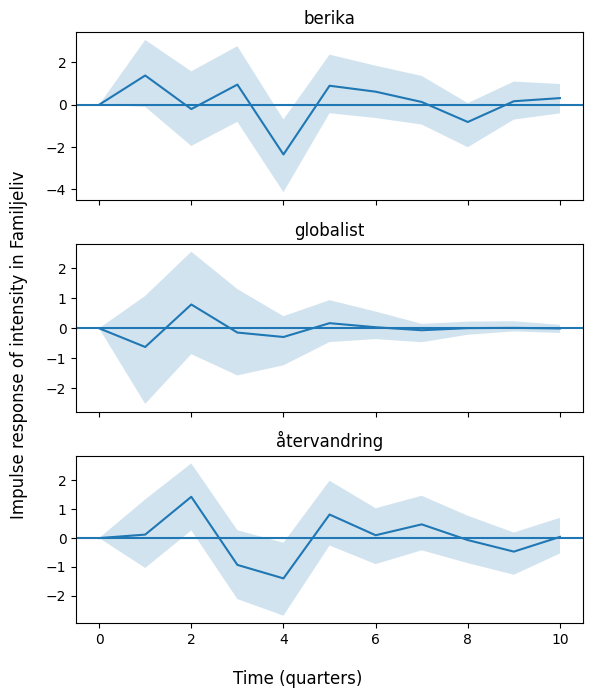

In [69]:
plot_multi_IRFS(IRFS,M_NAMES)

## Test All!

In [ ]:
def data_definer(path, file, year, month, day, fill, first_fill):
    file = Path(f"{path}/{file}")
    df = pd.read_csv(file, sep="\t", index_col=0)
    df = add_date(df, Q_mapper, set_as_index=False)
    df = df[df["date"] > pd.Timestamp(year=year, month=month, day=day)].copy()

    adj_int = adjusted(data=df, i_var="I_ang", f_var="fpm_lg", name="I_ang_adj", fill=fill, first_fill=first_fill)
    df = pd.concat([df, adj_int], axis=1)
    
    detrend_int = adjusted(data=df, i_var="I_ang", f_var="T", name="I_ang_dtr", fill=fill, first_fill=first_fill)
    df = pd.concat([df, detrend_int], axis=1)    
    
    detrend_ssc = adjusted(data=df, i_var="cnt_ssc", f_var="T", name="ssc_dtr", fill=fill, first_fill=first_fill)
    df = pd.concat([df, detrend_ssc], axis=1)  
    
    return df    

In [ ]:
def stationarity(df):
    a = df.fb.dropna()
    b = df.fl.dropna()
    return all([adf_test(a), adf_test(b), kpss_test(a), kpss_test(b)])

In [ ]:
PATHS = [
    "long_data",
    "long_data_no_min"
    ]

FILES = [
    "long_spec_q_rn.csv",
    "long_all_q_rn.csv",
    "sbert_long_spec_q_rn.csv",
    "sbert_mixed_long_all_q_rn.csv"    
    ]

In [ ]:
FF = [
    (0.5, None), 
    ("min", None), 
    ("mean", None), 
    ("interpolate", None),
    ("spline", None),
    ("previous", "next")
]

In [ ]:
PARADIGM = []
for fill, fill_start in FF:
    for meas in ["I_ang", "I_ang_dtr", "I_ang_adj"]:
        combo = (fill, fill_start, meas)
        PARADIGM.append(combo)
for fill, fill_start in FF:
    for meas in ["cnt_ssc", "ssc_dtr"]:
        combo = (fill, fill_start, meas)
        PARADIGM.append(combo)
# PARADIGM        

In [ ]:
DWEs = [
    "N1_globalist",
    "N1_återvandring",
    "V1_återvandra",
    "V1_berika",
    # "N1_kulturberikare"
]

In [ ]:
YEAR = 2010
MONTH = 1
DAY = 1

In [ ]:
len(PATHS)*len(FILES)*len(PARADIGM)*(2*len(DWEs))

In [ ]:
def mega_man():
    
    results = []

    for PATH in PATHS: 
        for FILE in FILES:
            for FILL, FIRST_FILL, MEAS in PARADIGM:

                print(f"{PATH}-{FILE}-{MEAS}-{FILL:<25}", end="\r")

                sqdf = data_definer(PATH, FILE, YEAR, MONTH, DAY, FILL, FIRST_FILL)

                # return sqdf
                # print(sqdf["I_ang"].corr(sqdf["I_ang_dtr"]))

                d = {"File": f"{PATH}/{FILE}", "Measure": f"{MEAS}", "Fill": f"{FILL}"}
                
                for TERM in DWEs:

                    # Time series
                    if MEAS.endswith("_dtr"):
                        payload = df_for_var(sqdf, TERM, MEAS)
                    else:
                        payload = df_for_var(sqdf, TERM, MEAS, FILL, FIRST_FILL)

                    # payload = df_for_var(sqdf, TERM, MEAS, FILL, FIRST_FILL)

                    if "var_model" in locals():
                        del var_model

                    optim_lag = find_lag(payload)
                    var_model = VAR(payload.dropna()).fit(optim_lag)

                    d[TERM]           = var_model.test_causality("fl", ["fb"], kind="f").pvalue
                    d[f"{TERM}_lag"]  = var_model.k_ar
                    d[f"{TERM}_stat"] = stationarity(payload)
                results.append(d)

                d = {"File": f"{PATH}/{FILE}", "Measure": f"{MEAS}", "Fill": f"{FILL}-Diff"}

                for TERM in DWEs:

                    # Differencing
                    payload = df_for_var(sqdf, TERM, MEAS, FILL, FIRST_FILL)
                    
                    payload["fb"] = differencing(payload, "fb")
                    payload["fl"] = differencing(payload, "fl")

                    del var_model
                    optim_lag = find_lag(payload)
                    var_model = VAR(payload.dropna()).fit(optim_lag)

                    d[TERM]           = var_model.test_causality("fl", ["fb"], kind="f").pvalue
                    d[f"{TERM}_lag"]  = var_model.k_ar
                    d[f"{TERM}_stat"] = stationarity(payload)
                results.append(d)

    results = pd.DataFrame(results)
    return results

In [ ]:
res = mega_man()

In [ ]:
th = 0.12
smp = res.copy()
smp = smp[(smp["V1_berika_stat"]==True)&(smp["N1_globalist_stat"]==True)&((smp["N1_återvandring_stat"]==True))]#|(smp["V1_återvandra_stat"]==True))]
smp = smp[(smp["V1_berika"]<=th)|(smp["N1_globalist"]<=th)|(smp["N1_återvandring"]<=th)|(smp["V1_återvandra"]<=th)]
# smp = smp[(smp["V1_berika"]<=th)&(smp["N1_globalist"]<=th)&((smp["N1_återvandring"]<=th))]#|(smp["V1_återvandra"]<=th))]
print(smp.shape)
sns.heatmap(smp[DWEs])

In [ ]:
smp[["File","Measure"]+DWEs].round(2)

In [ ]:
smp.to_excel("c:/Users/xbohma/Desktop/mamma_mu.xlsx")

In [ ]:
sorted(list(set(smp.Measure.tolist())))

In [ ]:
smp

In [ ]:
smp[smp["Measure"].isin(['I_ang-0.5-Diff', 'I_ang-min-Diff'])]

In [ ]:
res[(res["N1_återvandring"]<th)&(res["V1_återvandra"]>th)][[c for c in res.columns if "åter" in c]]

In [ ]:
res[(res["N1_återvandring"]>th)&(res["V1_återvandra"]<th)][[c for c in res.columns if "åter" in c]]